Messing around with Twitter API and PANDAS

# Load tweets into a text file

In [5]:
import tweepy
import config 
import json
from tweepy import OAuthHandler

auth = OAuthHandler(config.consumer_key,config.consumer_secret)
auth.set_access_token(config.access_token,config.access_secret)
api = tweepy.API(auth)

def store(tweet):
    output.write(json.dumps(tweet)+'\n')

file_name = 'trumptweets.json'
output = open(file_name,"w")

num_tweets = 3000                  # number of tweets to retrieve
twitter_id = 'realDonaldTrump'     # userid 

for tweet in tweepy.Cursor(api.user_timeline, id=twitter_id).items(num_tweets):
    store(tweet._json)
    
output.close()


# Parse JSON data

In [6]:
import json
import pandas as pd 

def load_tweets(file):
    with open(file,'r') as f:
        tweets = (json.loads(line) for i, line in enumerate(f.readlines()))
    return tweets

# Select the attributes needed
data = {'text': [], 'created_at': [], 'retweet_count': [], 'favorite_count': [], 'followers_count': []}
        
tweets = load_tweets(file_name)
for t in tweets:
    data['text'].append(t['text'])
    data['retweet_count'].append(t['retweet_count'])
    data['created_at'].append(t['created_at'])
    data['favorite_count'].append(t['favorite_count'])
    data['followers_count'].append(t['user']['followers_count'])
    
df = pd.DataFrame(data)
df['created_at'] = pd.to_datetime(df['created_at']) # convert to datetime data type

df.sort_values(by='created_at') 

,created_at,favorite_count,followers_count,retweet_count,text
2999,2016-04-10 03:04:56,9946,25608304,3488,"""@AnnCoulter: GOP is trying to steal nominatio..."
2998,2016-04-10 03:05:28,11979,25608304,4294,"""@metalmom888: @Theresa_Cali If the GOP screw..."
2997,2016-04-10 03:10:16,12681,25608304,4932,"""@becker_berta: @vivhall3 @Reince Millions mor..."
2996,2016-04-10 03:17:30,8367,25608304,2551,"""@jlopez05391: @realDonaldTrump Rochester love..."
2995,2016-04-10 11:25:38,6797,25608304,2023,"""@getreal1234: @realDonaldTrump @Kids123Nichol..."
2994,2016-04-10 11:29:49,8511,25608304,3523,"""@agentvf: New Jersey Man Joseph Hornick Willi..."
2993,2016-04-10 13:40:23,14223,25608304,5160,The @nytimes purposely covers me so inaccurate...
2992,2016-04-10 13:47:57,25911,25608304,9782,I win a state in votes and then get non-repres...
2991,2016-04-10 19:23:50,8432,25608304,3411,#MakeAmericaGreatAgain #Trump2016\nhttps://t.c...
2990,2016-04-11 00:28:54,27160,25608304,10186,How is it possible that the people of the grea...


# Looking at Favorite and Retweet Counts

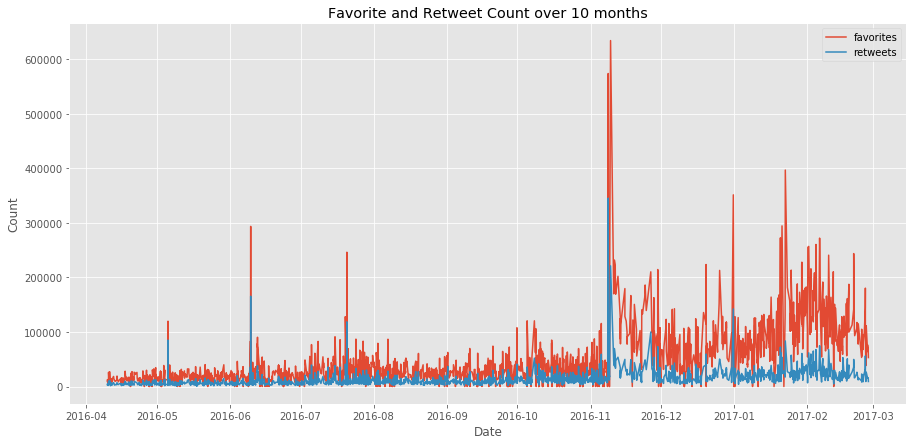

In [7]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize = (15,7))
num_days = (max(df['created_at']) - min(df['created_at'])).days
num_months = int(num_days/30)
plt.title('Favorite and Retweet Count over ' + str(num_months) + ' months')
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(df['created_at'],df['favorite_count'],label='favorite count')
plt.plot(df['created_at'],df['retweet_count'],label='retweet count')
plt.legend(['favorites','retweets'])
plt.show()

In [8]:
max_favorite_count = max(df['favorite_count'])
most_favorited_tweet = df.ix[df['favorite_count'].idxmax()]['text']

print("Donald Trump's most favorited tweet with " + str(max_favorite_count) + " tweets:\n" + most_favorited_tweet)

Donald Trump's most favorited tweet with 633798 tweets:
Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never before


# Word Frequency

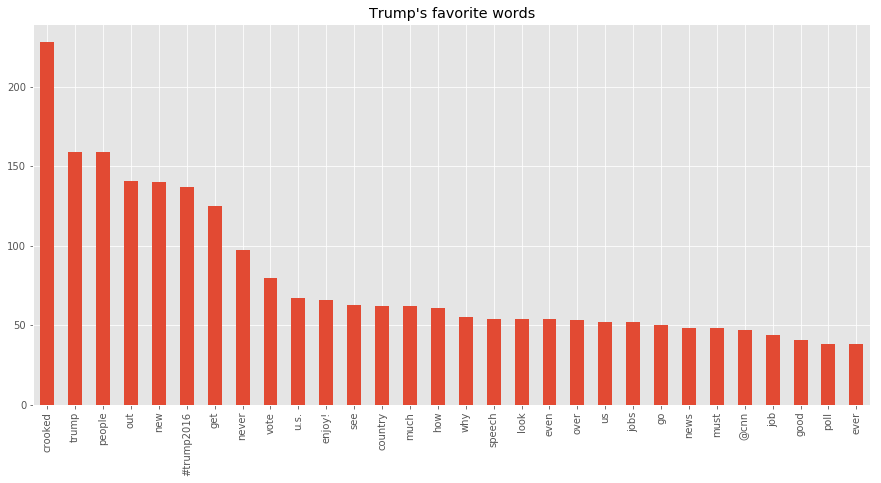

In [17]:
word_series = pd.Series(' '.join(df['text']).lower().split()) 
stop_words = ['the','is','of','at','to','be','and','in','a','will','for','on','with','i','you','we','our','my','it',
              '-','by','me','not','just','rt','so','very','she','from','who','her','but','no','or','he','up','would','should',
              'do']
filt  = list(filter(lambda word: not any(s in word for s in stop_words), word_series)) # filter stop words

plt.figure(figsize=(15,7))
plt.title("Trump's favorite words")

N = 30
word_freq = pd.Series(filt).value_counts()[:N]           # top N words
word_freq.plot(kind='bar')                               # how to rotate ticks?
plt.show()

# Account Activity

In [9]:
# TODO